# Results Explorer for pendulum models

includes plotting the sindy coefficients $\Xi$, loss metrics and trajectories for different initial conditions 

### Choose Model

In [35]:
#CHOOSE MODEL
model_path = "KathleenReplicas/version_6"
#CHOOSE MODEL
#good versions
#version_3
#version_6

In [36]:
import sys
sys.path.append('../')
from trainer import SINDy_trainer, update_mask
import jax.numpy as jnp
import numpy as np

# if we are not training any further the example input can be any shape
exmp_input = jnp.ones((1, 128))
trainer = SINDy_trainer.load_from_checkpoint(model_path, exmp_input)

xi_raw = trainer.state.params['sindy_coefficients']


mask = update_mask(xi_raw)

library_hparams = trainer.library_hparams

xi = xi_raw * mask


xi = np.array(xi)


In [37]:
print(xi)

[[-0.       ]
 [-0.       ]
 [-0.       ]
 [ 0.       ]
 [ 0.       ]
 [-0.       ]
 [ 0.       ]
 [-0.       ]
 [ 0.       ]
 [ 0.       ]
 [-1.0011816]
 [-0.       ]]


In [38]:
####### TODO: This block should be removed before final delivery

import sys
sys.path.append('../')
import jax.numpy as jnp
import numpy as np

#Create dummy Xi for testing

library_hparams = {"poly_order": 3, "n_states": 2, "include_sine": True, "include_constant": True}

#xi = np.array([[1,0,0], [0,-2,1], [7,2.4,0], [12,0,-8], [1,-1,0]] + 15*[[0,0,0]])

### Printing discovered equations

In [39]:
import matplotlib.pyplot as plt
from sindyLibrary import get_row_context

row_context = get_row_context(library_hparams)

lib_size, n_states = xi.shape

text = r"$$ \begin{align*}"

for i in range(n_states):
    first = True
    text += r"\dot{z}_" + f"{i+1}" + r" =& "
    for (x, y) in zip(xi, row_context):
        coeff = x[i]
        if coeff != 0:
            if coeff > 0 and not first:
                text += "+"
            text += f"{coeff:.2f} {y}"
            first = False
    text += r"\\"

text += r"\end{align*} $$"
from IPython.display import display, Latex
display(Latex(text))
    

<IPython.core.display.Latex object>

### Plotting $\Xi$

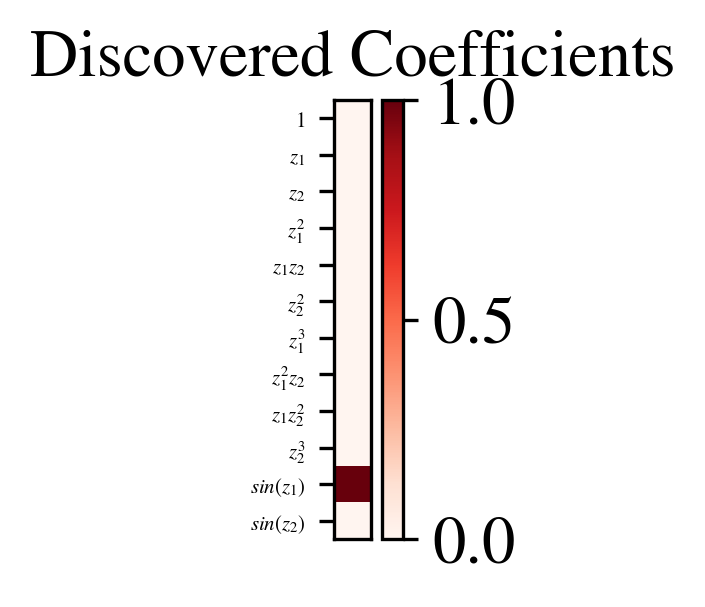

In [40]:
# sys.path.append('../plot_utils')
import matplotlib.pyplot as plt
from plot_utils.plot_xi import plot_sindy_coefficients


plt.style.use("../plot_utils/plot_settings.mplstyle")
plot_sindy_coefficients(xi, library_hparams = library_hparams, save_path="xi_plot.png")

### Plot difference between discovered coefficients ($\Xi$) and actual coefficients

The correct equation for the pedulum is the following:

$$
\begin{aligned}

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$
That is:
$$
\begin{aligned}
\dot{z}_1 =& -10 z_1 + 10 z_2 \\
\dot{z}_2 =& 28 z_1 - z_2 - z_1 z_3 \\
\dot{z}_3 =& -\frac{8}{3}z_3 + z_1 z_2 \\
\end{aligned}
$$
We create an array with the theoretical values, in order to compare with the values from our model

In [58]:
#Currently this is assuming include_constant=True, include_sine=False, n_states=3, poly_order=3
# Should look into generalizing this if we want to use it for all models

true_xi = np.array([[0,0,0], [-10, 28,0], [10, -1, 0], [0, 0, -8/3], [0,0,0], [0,0,1], [0,-1,0]] + 13*[[0,0,0]])

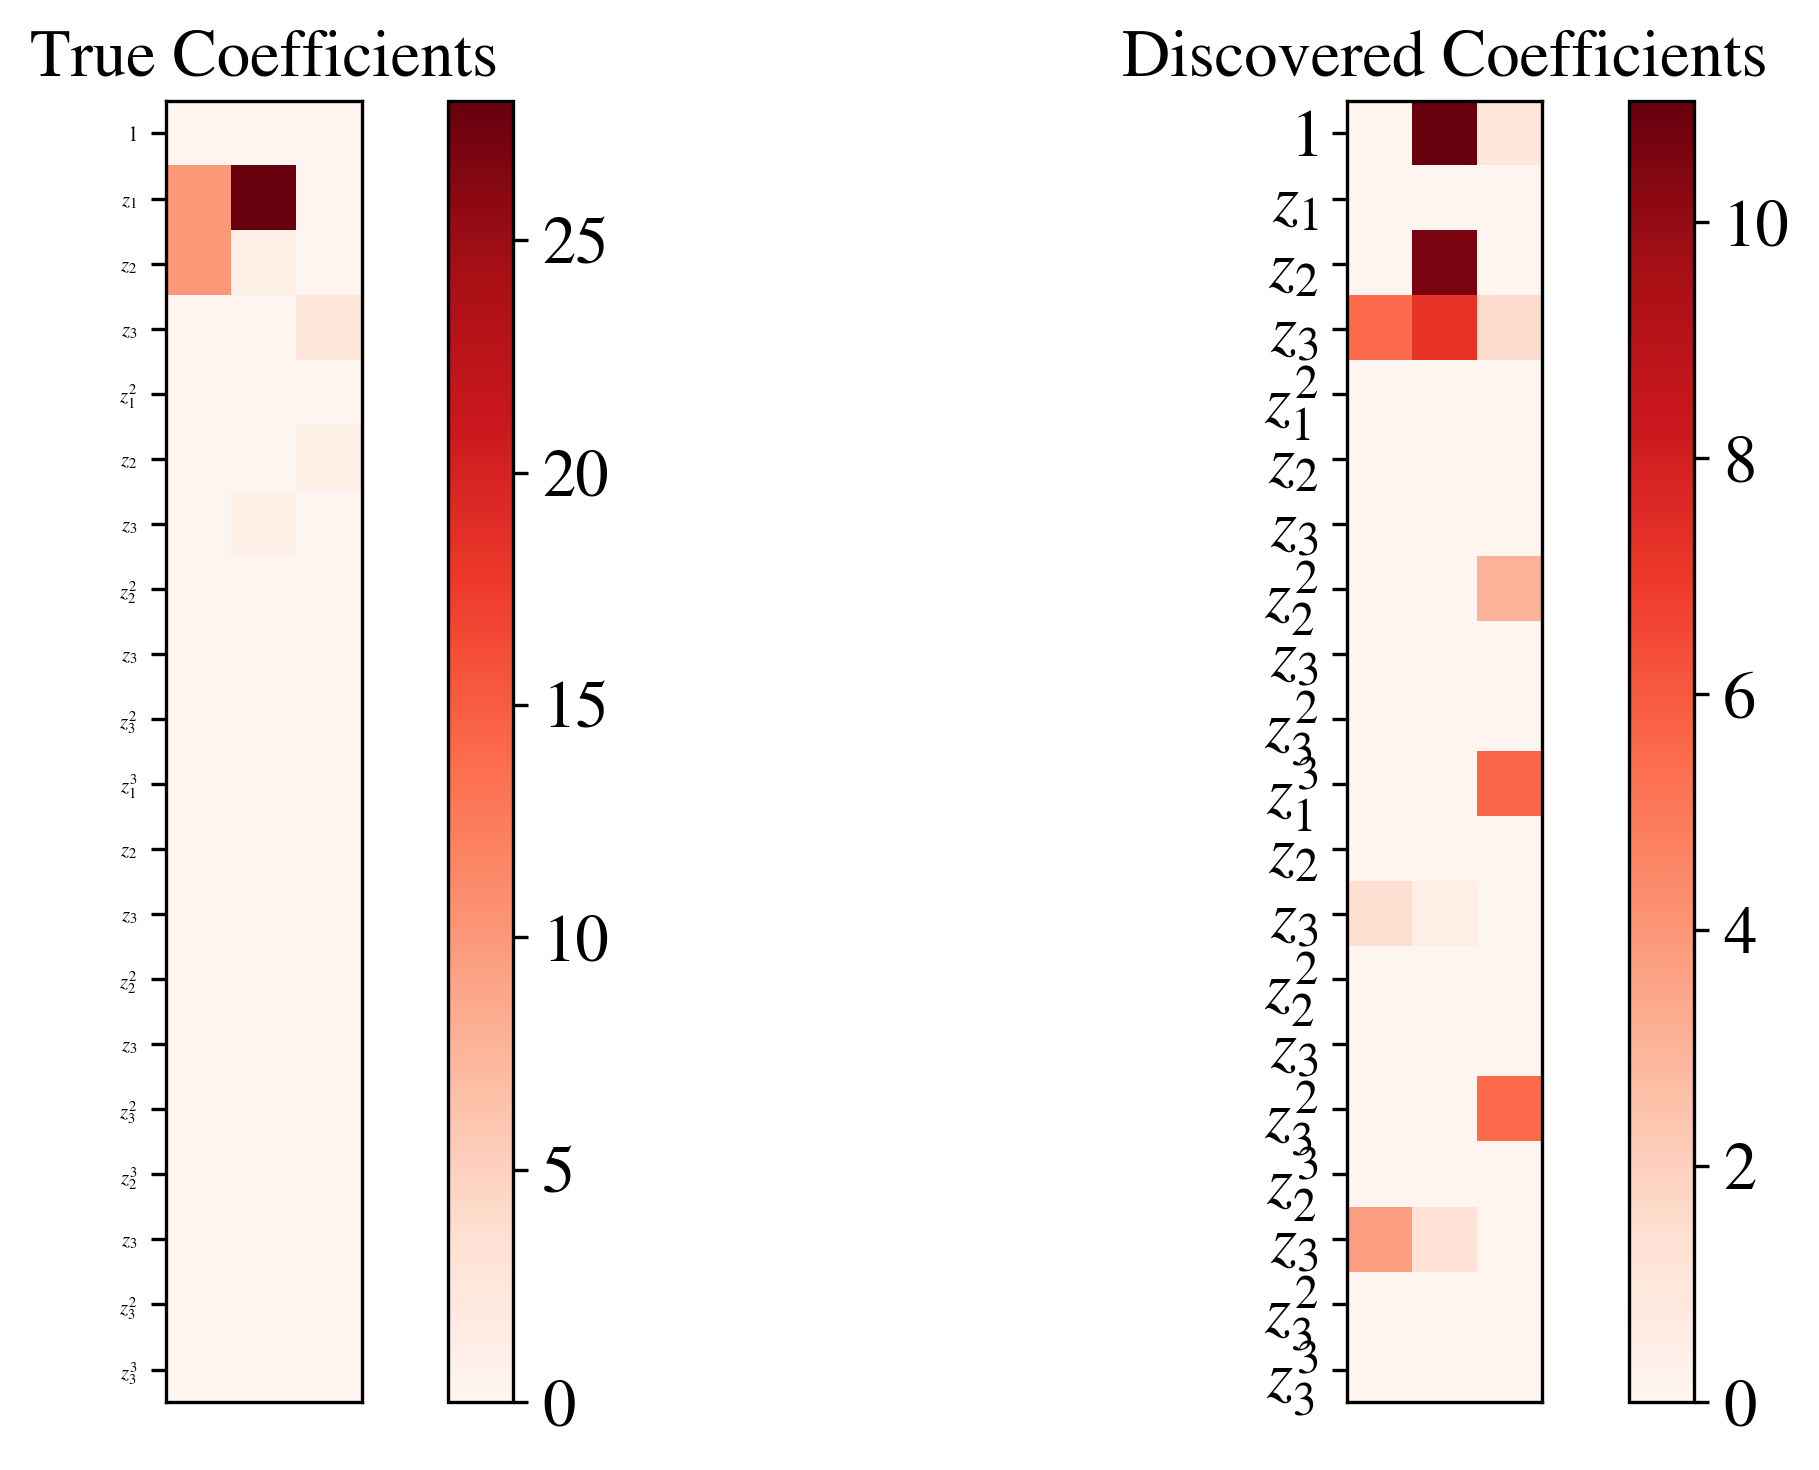

In [59]:
from plot_utils.plot_xi import compare_sindy_coefficients

plt.style.use("../plot_utils/plot_settings.mplstyle")
compare_sindy_coefficients(true_xi, xi, library_hparams = library_hparams, save_path="xi_plot.png")

### Plot losses

In [ ]:
from plot_utils.metrics import RunMetrics # type: ignore -goofy linitng issue
from plot_utils.plot_metrics import plot_metrics # type: ignore -goofy linitng issue


metrics = RunMetrics(model_path)

# Plot a single run
plot_metrics(metrics, metric_names=["train/loss", "val/loss"], title="Loss Metrics")

ModuleNotFoundError: No module named 'metrics'